In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= '2.0'
from tensorflow import keras

import numpy as np
import pandas as pd
import scipy
import os
import time

from constants import *
from data import CSVDataHandler

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def plot_property(data_:pdSeries):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax.grid()
    plt.plot(data_)

In [3]:
def plot_ticker(data_:pdFrame, oc_width:int=5, hl_width:int=1):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    ax.grid()        
    plt.plot(data_.index, data_.open, 'g--')
    palette = ['r' if o > c else 'g' for (o,c) in data_[['open','close']].values]
    plt.vlines(data_.index, data_.open, data_.close, colors=palette, linestyles='solid', linewidth=oc_width)
    plt.vlines(data_.index, data_.low, data_.high, colors=palette, linestyles='solid', linewidth=hl_width)
    plt.show()

In [4]:
def plot_max_min(data_: pdFrame, grid:bool = True):
    fig = plt.figure(figsize = FIGURE_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    if grid:
        minor_ticks = np.array(data_.index)
        ax.set_xticks(minor_ticks, minor=True)
        ax.grid(which='minor', alpha=0.5)
        ax.grid('both')

    plt.plot(data_.close, 'g--')
    plt.plot(data_.butter, 'r-')
    plt.plot(data_.butter_min, 'b.')
    plt.plot(data_.butter_max, 'k.')
    plt.plot(data_.close_min, 'g^')
    plt.plot(data_.close_max, 'rv')
    plt.show()

---
## Data loading

In [131]:
%%time
bars = CSVDataHandler('data', TIMEFRAME_DAY,
           {'UVXY': {'src': 'av', 'tz': 'US/Eastern', 'exn':True, 'file':'UVXY_daily.csv'}, 
            'IMOEX': {'src': 'finam', 'tz': 'Europe/Moscow'},
            'SPFB': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False},
            'SI': {'src': 'finam', 'tz': 'Europe/Moscow', 'exn': False}
           })

Wall time: 7.41 s


In [132]:
df = bars.all_bars('SPFB')
df.head()

,open,high,low,close,volume
datetime,,,,,
2009-07-17,63.73,64.32,63.70,64.30,1017.0
2009-07-18,63.97,66.42,63.96,66.20,1623.0
2009-07-21,66.66,67.39,66.38,67.39,644.0
2009-07-22,66.63,68.50,66.63,67.12,242.0
2009-07-23,67.33,68.01,66.63,67.90,123.0


In [133]:
df.describe()

,open,high,low,close,volume
count,2538.000000,2538.000000,2538.000000,2538.000000,2.538000e+03
mean,80.148262,81.052939,79.180307,80.139594,6.682231e+05
std,25.245511,25.319671,25.153717,25.262106,8.901607e+05
min,28.140000,28.950000,27.080000,28.190000,6.100000e+01
25%,58.000000,59.005000,56.997500,58.025000,3.132350e+04
50%,76.145000,77.020000,75.110000,76.100000,7.524550e+04
75%,107.487500,108.277500,106.607500,107.517500,1.340607e+06
max,126.010000,127.020000,124.820000,126.910000,5.085567e+06


In [134]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2538 entries, 2009-07-17 to 2019-08-31
Data columns (total 5 columns):
open      2538 non-null float64
high      2538 non-null float64
low       2538 non-null float64
close     2538 non-null float64
volume    2538 non-null float64
dtypes: float64(5)
memory usage: 119.0 KB


In [9]:
m = 3*10**3
train_data = df.iloc[:m, :]
test_data = df.iloc[m:, :]
print(train_data.shape[0])
print(test_data.shape[0])

3000
1972


----
## Data exloration

In [135]:
df = bars.all_bars('SPFB').reset_index() #[:1000]
df.head()

,datetime,open,high,low,close,volume
0,2009-07-17,63.73,64.32,63.70,64.30,1017.0
1,2009-07-18,63.97,66.42,63.96,66.20,1623.0
2,2009-07-21,66.66,67.39,66.38,67.39,644.0
3,2009-07-22,66.63,68.50,66.63,67.12,242.0
4,2009-07-23,67.33,68.01,66.63,67.90,123.0


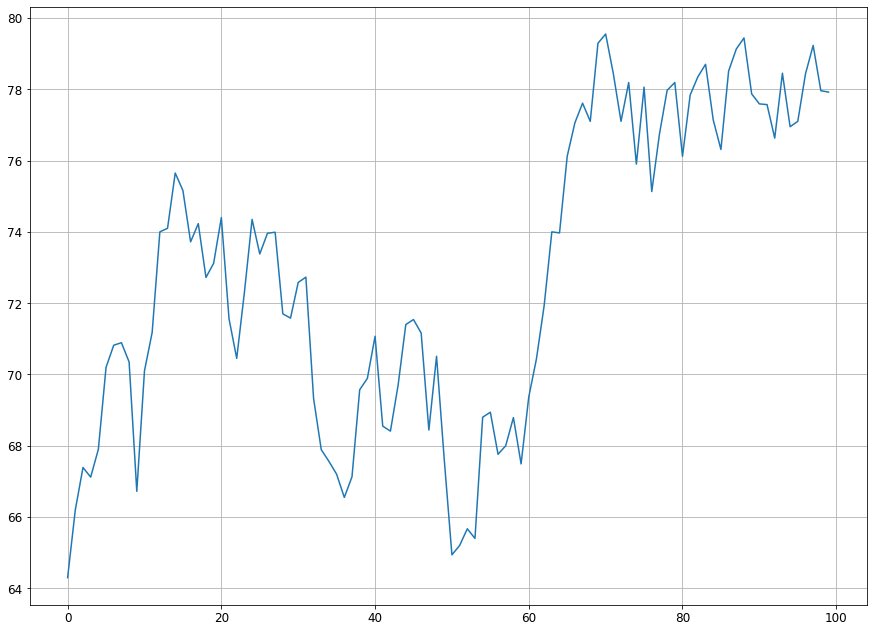

In [136]:
plot_property(df.close[:100])

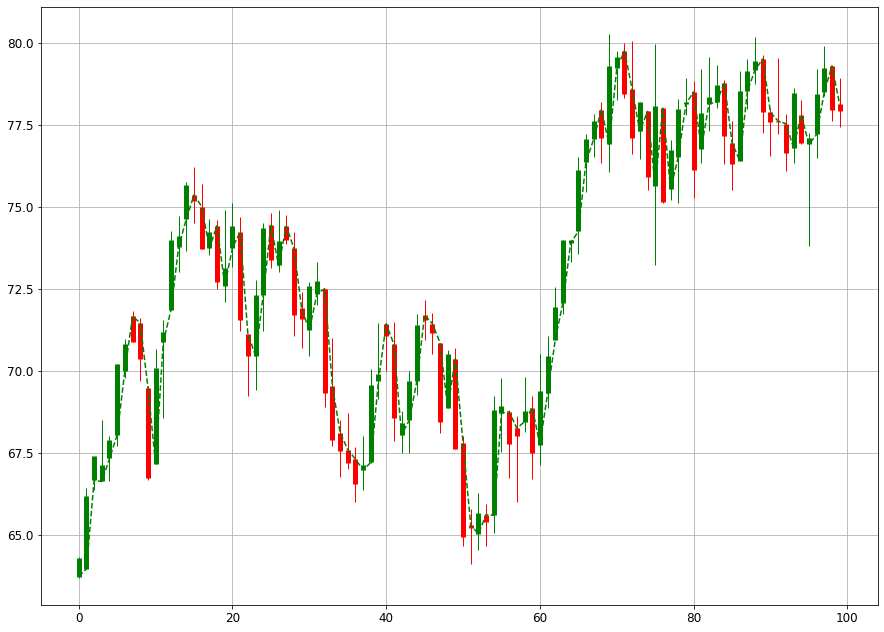

In [137]:
plot_ticker(df[['open','high','low','close']][:100])

### Forming target

In [30]:
from scipy import signal

def apply_butter_filter(data_:pdFrame, n, hc, skip) -> pdFrame:
    filter_ = signal.butter(n, 1/hc, output='sos')
    data_['butter'] = scipy.signal.sosfilt(filter_, data_.close)
    return data_[skip:]

In [31]:
import operator

def find_extrem(data_:pdSeries, is_max:bool, strict:bool=True) -> pdSeries:
    op_extr = operator.lt if is_max else operator.gt 
    op_not_strict = operator.le if is_max else operator.ge
    if strict:
        return op_extr(data_.shift(1), data_) & op_extr(data_.shift(-1), data_)
    else:
        return op_not_strict(data_.shift(1), data_) & op_extr(data_.shift(-1), data_)

In [138]:
df = apply_butter_filter(df, 2, 8, 3*8)
df.head()

,datetime,open,high,low,close,volume,butter
24,2009-08-20,72.30,74.50,71.21,74.35,24571.0,72.744557
25,2009-08-21,74.43,74.80,73.13,73.38,40918.0,72.641634
26,2009-08-22,73.21,74.89,73.00,73.96,24374.0,72.717450
27,2009-08-25,74.40,74.75,73.86,73.99,21849.0,72.893378
28,2009-08-26,73.73,74.23,71.05,71.70,17110.0,73.056272


In [139]:
df.loc[find_extrem(df.butter, False, True), 'butter_min'] = df.butter
df.loc[find_extrem(df.butter, True, True), 'butter_max'] = df.butter
df.loc[find_extrem(df.close, False, False), 'close_min'] = df.close
df.loc[find_extrem(df.close, True, False), 'close_max'] = df.close

In [140]:
df.head(15)

,datetime,open,high,low,close,volume,butter,butter_min,butter_max,close_min,close_max
24,2009-08-20,72.30,74.50,71.21,74.35,24571.0,72.744557,NaN,NaN,NaN,NaN
25,2009-08-21,74.43,74.80,73.13,73.38,40918.0,72.641634,72.641634,NaN,73.38,NaN
26,2009-08-22,73.21,74.89,73.00,73.96,24374.0,72.717450,NaN,NaN,NaN,NaN
27,2009-08-25,74.40,74.75,73.86,73.99,21849.0,72.893378,NaN,NaN,NaN,73.99
28,2009-08-26,73.73,74.23,71.05,71.70,17110.0,73.056272,NaN,73.056272,NaN,NaN
29,2009-08-27,71.90,72.41,70.71,71.58,17056.0,73.052279,NaN,NaN,71.58,NaN
30,2009-08-28,71.23,72.70,70.44,72.58,18464.0,72.907129,NaN,NaN,NaN,NaN
31,2009-08-29,72.35,73.32,72.01,72.73,20827.0,72.759147,NaN,NaN,NaN,72.73
32,2009-09-01,72.50,72.50,68.91,69.33,31432.0,72.564365,NaN,NaN,NaN,NaN
33,2009-09-02,69.54,71.00,67.72,67.89,35861.0,72.123723,NaN,NaN,NaN,NaN


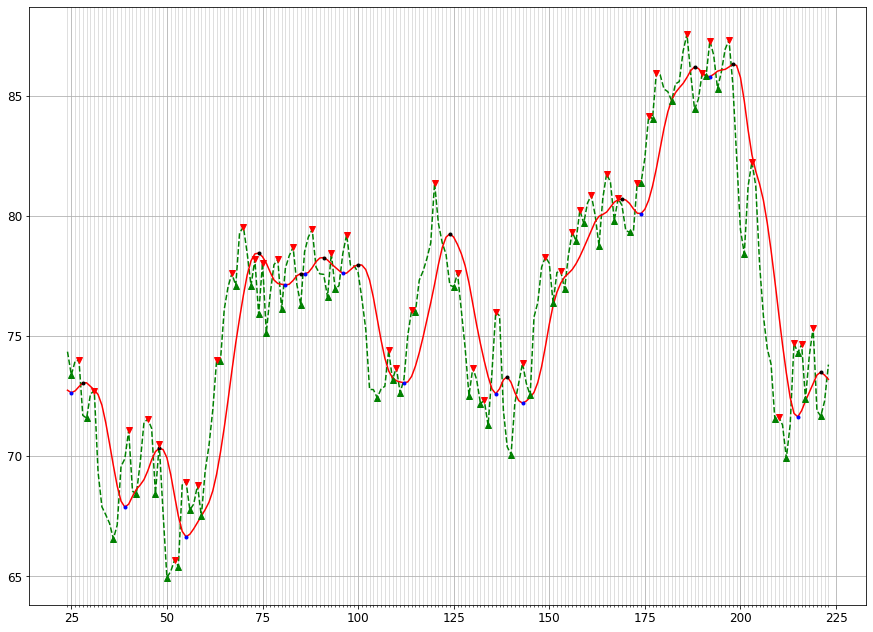

In [141]:
df_copy = df.copy()
plot_max_min(df_copy[:200])

In [83]:
def find_min(fst, fst_idx, snd, snd_idx) -> (int, bool):
    if (fst_idx >= len(fst)) and (snd_idx >= len(snd)):
        return (-1, True)
    if fst_idx >= len(fst): 
        return (snd_idx, False) 
    if snd_idx >= len(snd): 
        return (fst_idx, True)
    if fst[fst_idx] > snd[snd_idx]:
        return (snd_idx, False) 
    else:
        return (fst_idx, True)
    
def select_indices(filter_max, data_max, filter_min, data_min, data_:pdSeries):
    fmax_idx = 0; fmin_idx = 0
    dmax_idx = 0; dmin_idx = 0
    result_max = []; result_min = []
    prev_vals = []
    fi, is_max = find_min(filter_max, fmax_idx, filter_min, fmin_idx)
    while fi >= 0:
        f = filter_max if is_max else filter_min
        d = data_max if is_max else data_min
        i = dmax_idx if is_max else dmin_idx
        min_max = max if is_max else min
        while (i < len(d)) and (d[i] <= f[fi]):
            prev_vals.append(data_[d[i]])
            i += 1
        if len(prev_vals) > 0:
            # returns index of the last min/max value
            idx = min_max(range(len(prev_vals)), key=lambda j: (prev_vals[j], -j))
            if is_max:
                result_max.append(d[i - len(prev_vals) + idx])
                dmax_idx = i
                while data_min[dmin_idx] < result_max[-1]:
                    dmin_idx += 1
            else:
                result_min.append(d[i - len(prev_vals) + idx])
                dmin_idx = i
                while data_max[dmax_idx] < result_min[-1]:
                    dmax_idx += 1
            prev_vals = []
        if is_max:
            fmax_idx += 1
        else:
            fmin_idx += 1
        fi, is_max = find_min(filter_max, fmax_idx, filter_min, fmin_idx)
    return result_max, result_min

In [142]:
max_idx, min_idx = select_indices(np.array(df[df.butter_max.notnull()].index), 
                                  np.array(df[df.close_max.notnull()].index),
                                  np.array(df[df.butter_min.notnull()].index),  
                                  np.array(df[df.close_min.notnull()].index), 
                                  df.close)
df.close_min = np.NaN
df.loc[df.index.isin(min_idx), 'close_min'] = df.close
df.close_max = np.NaN
df.loc[df.index.isin(max_idx), 'close_max'] = df.close

In [143]:
df[:50]

,datetime,open,high,low,close,volume,butter,butter_min,butter_max,close_min,close_max
24,2009-08-20,72.30,74.50,71.21,74.35,24571.0,72.744557,NaN,NaN,NaN,NaN
25,2009-08-21,74.43,74.80,73.13,73.38,40918.0,72.641634,72.641634,NaN,73.38,NaN
26,2009-08-22,73.21,74.89,73.00,73.96,24374.0,72.717450,NaN,NaN,NaN,NaN
27,2009-08-25,74.40,74.75,73.86,73.99,21849.0,72.893378,NaN,NaN,NaN,73.99
28,2009-08-26,73.73,74.23,71.05,71.70,17110.0,73.056272,NaN,73.056272,NaN,NaN
29,2009-08-27,71.90,72.41,70.71,71.58,17056.0,73.052279,NaN,NaN,NaN,NaN
30,2009-08-28,71.23,72.70,70.44,72.58,18464.0,72.907129,NaN,NaN,NaN,NaN
31,2009-08-29,72.35,73.32,72.01,72.73,20827.0,72.759147,NaN,NaN,NaN,NaN
32,2009-09-01,72.50,72.50,68.91,69.33,31432.0,72.564365,NaN,NaN,NaN,NaN
33,2009-09-02,69.54,71.00,67.72,67.89,35861.0,72.123723,NaN,NaN,NaN,NaN


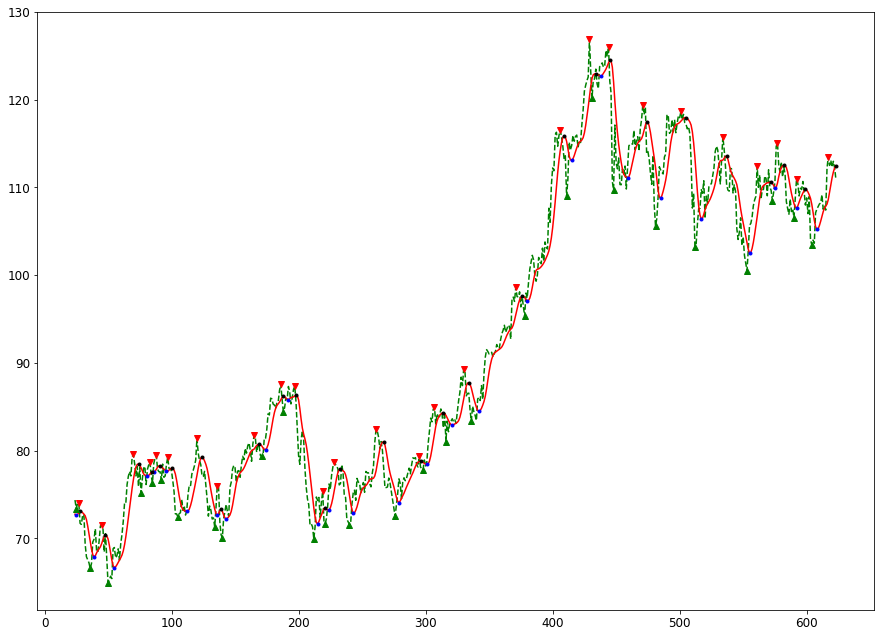

In [144]:
plot_max_min(df[:600], False)

In [66]:
def calc_trades(data_max, data_min):
    i = j = 0
    num_ = sum_ = 0
    prev_val = 0.0
    prev_max = data_min[0] < data_max[0]
    
    while i < len(data_min) and j < len(data_max): 
        if data_min[i] < data_max[j]: 
            if prev_max:
                sum_ += (data_min[i] - prev_val)
                num_ += 2
                prev_val = data_min[i]
            i+=1
        else: # data_min[i] > data_max[j]: 
            if not prev_max:
                sum_ += (data_max[j] - prev_val)
                num_ += 2
                prev_val = data_max[j]
            j+=1
    return num_, sum_/num_

In [145]:
calc_trades(np.array(df[df.close_max.notnull()].index), 
            np.array(df[df.close_min.notnull()].index))

(246, 10.24390243902439)

----
## Debug notes

In [55]:
def select_indices(op, filter_idx, data_idx, data_:pdSeries):
    result = []
    prev_vals = []
    i = 0
    for fi in filter_idx:
        while (i < len(data_idx)) and (data_idx[i] <= fi):
            prev_vals.append(data_[data_idx[i]])
            i += 1
        if (i > 0) and (len(prev_vals) > 0):
            mi = 1
            if (len(prev_vals) > 1) and op(prev_vals[-2], prev_vals[-1]):
                mi = 2
            result.append(data_idx[i - mi])
            prev_vals = []
    return result

In [155]:
def select_indices(filter_idx, data_idx, func_, data_:pdSeries):
    result = []
    prev_vals = []
    i = 0
    for fi in filter_idx:
        while (i < len(data_idx)) and (data_idx[i] <= fi):
            prev_vals.append(data_[data_idx[i]])
            i += 1
        if (i > 0) and (len(prev_vals) > 0):
            # consider no more than 3 last max/mins
            prev_vals = prev_vals[-3:]
            # returns index of the last min/max value
            idx = func_(range(len(prev_vals)), key=lambda j: (prev_vals[j], -j))
            result.append(data_idx[i - len(prev_vals) + idx])
            prev_vals = []
    return result